## Tutorial 18 - Numerical minimization methods

For this tutorial, we're going to look at the simulated "emission line" data that we used in Tutorial 17 to see how numerical minimization can be used to simplify the process of parameter estimation.

In [178]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

The flux of the emission line as a function of photon energy is given by

$$F(E) = A \cdot \exp\left(\left(\frac{E - E_0}{2 \Delta E}\right)^2\right)$$

where 
* $A$ is the amplitude
* $E_0$ is the line location
* $\Delta E$ is the line width

In [179]:
# function to give you the expected counts from the emission line
def emiss_line(Es, A, E0, width):
    '''
    Es: your array of photon energies (eV)
    A: the emission line amplitude (counts)
    E0: the center of your emission line (eV)
    width: the width of your emission line (eV)
    '''
    return A * np.exp(-((Es - E0)/(2 * width))**2)

In [180]:
np.random.seed(100)

def generate_data(Es, A = 15, E0 = 2.0, width = 0.05, cont_rate = 20):
    '''
    Es: your array of photon energies (eV)
    A: the emission line amplitude (counts)
    E0: the center of your emission line (eV)
    width: the width of your emission line (eV)
    cont_rate: the counts at each energy from the flat continuum

    Returns the simulated data emission line + continuum with noise
    '''

    # simulate your continum counts
    counts_cont = np.random.poisson(lam=cont_rate, size=len(Es))

    # Find the expected emission line counts give the true parameters
    emiss_line_avg = emiss_line(Es, A, E0, width)

    # simulate the counts from the emission line
    counts_line = np.random.poisson(lam=emiss_line_avg)

    return counts_cont + counts_line

In [181]:
Ephotons = np.arange(1, 3, 0.01)
counts_data = generate_data(Ephotons)               # generate the data set we used last time

Text(0, 0.5, 'Counts')

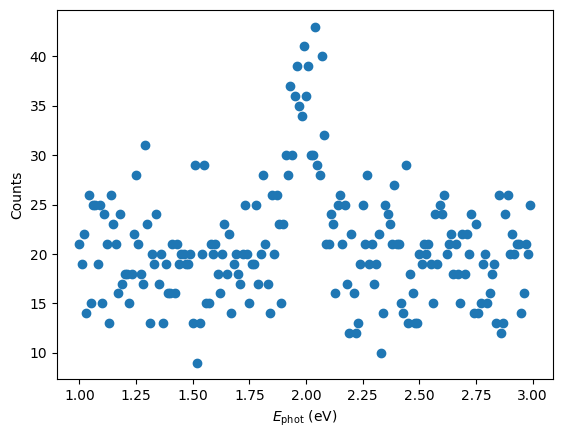

In [182]:
# Plot the data set
plt.plot(Ephotons, counts_data, 'o')
plt.xlabel('$E_\mathrm{phot}$ (eV)')
plt.ylabel('Counts')

Find the 1-$\sigma$ error on each observation of the counts.

In [183]:
sigmas = np.sqrt(counts_data)  # Poisson error

Recall from the last tutorial that we can find the best fit value of a parameter by minimizing the $\chi^2$ value. 

This time let's assume we know 
- the continuum gives an average of 20 counts 
- the amplitude $A$ of the line is 25 counts
- the line location $E_0$ 

Let's find what the data can tell us about the line width.

First, write a function for the emission line + continuum counts:

In [184]:
def calc_counts(Es, A, E0, width, cont_rate):
    '''
    Input:
        Es: your array of photon energies (eV)'
        A: the emission line amplitude (counts)
        E0: the center of your emission line (eV)'
        width: the width of your emission line (eV)''
        cont_rate: the counts at each energy from the flat continuum'

    Output:
        total_count: the expected counts from the emission line + continuum
    '''
    emiss_line_count = emiss_line(Es, A, E0, width)
    
    return emiss_line_count + cont_rate


In order to set up the chi2 function so that it can be minimized using `scipy.optimize.minimize`, we need to write it such that it takes the inputs to `emiss_line` as inputs (`Es`,`A`, `E0`, `width`), as well as the `counts_data` and the **sigmas**. Remember that the *first* input should be the variable parameter.

In [185]:
def calc_chi2(width, A, E0, cont_rate, counts_data, sigmas):
    '''
    Input:
        width: the width of your emission line (eV)'
        A: the emission line amplitude (counts)
        E0: the center of your emission line (eV)'
        cont_rate: the counts at each energy from the flat continuum'
        counts_data: the data set we used last time
        sigmas: the error on the data set

    Output:
        chi2: the chi2 value of the fit
    '''
    # Calculate the expected counts from the emission line
    expected_counts = calc_counts(Ephotons, A, E0, width, cont_rate)    
    # Calculate the chi2 value
    chi2 = np.sum((counts_data - expected_counts)**2 / sigmas**2)
    
    return chi2

Now we can apply the `minimize` function.

In [186]:
# Now we will use the minimize function to find the best fit parameters
# We will start with an initial guess of width = 0.1

#This time let's assume we know 
#- the continuum gives an average of 20 counts 
#- the amplitude $A$ of the line is 25 counts
#- the line location $E_0$ 

cont_avg = 20
A = 25
E0 = 2.0 #Not given but assuming its 2.0 eV from the graph

bounds = [(0, None)]  # E0 >= 0

results_1 = minimize(calc_chi2, x0=0.5, args=(A, E0, cont_avg, counts_data, sigmas), bounds=bounds)
print(results_1)

print(f"The miniminum chi2 value is: {results_1.fun:0.3f} at line width: {results_1.x[0]:0.3f} eV")

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 220.29312209805812
        x: [ 3.409e-02]
      nit: 5
      jac: [-5.684e-06]
     nfev: 22
     njev: 11
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
The miniminum chi2 value is: 220.293 at line width: 0.034 eV


C:\Users\Insan\AppData\Local\Temp\ipykernel_22256\20533712.py:9: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-((Es - E0)/(2 * width))**2)


However, the beauty of `minimize` is that it makes it easy to minimize the function over multiple parameters at once.

* Redefine your `calc_chi2` function so that we can minimize over all three variables to the emission line function, amplitude `A`, line location `E0`, and `width`. 
* Remember that you need to need your variables to be input as a single argument, an array of 3 values

In [190]:
def calc_chi2(var, cont_rate, counts_data, sigmas):

    A, E0, width = var
    
    # Calculate the expected counts from the emission line
    expected_counts = calc_counts(Ephotons, A, E0, width, cont_rate)    
    # Calculate the chi2 value
    chi2 = np.sum((counts_data - expected_counts)**2 / sigmas**2)

    return chi2

Choose "guess" values for `A`, `E0` and `width` (but don't use the "true" values that we used to generate the data in the beginning). 

In [195]:
init_guess = [20.0, 1.75, 0.1]

# Define bounds for the parameters: (min, max) for each parameter
# Here, we constrain all parameters to be non-negative
bounds = [(1, None),  # A >= 0
          (1, None),  # E0 >= 0
          (0.001, None)]  # width >= 0.001

results_2 = minimize(calc_chi2, x0=init_guess, args=(cont_avg, counts_data, sigmas), bounds=bounds)
print(results_2)

best_A = results_2.x[0]
best_E = results_2.x[1]
best_width = results_2.x[2]
print(f"The best fit parameters are: A = {best_A}, E0 = {best_E}, width = {best_width}")

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 209.38542015443252
        x: [ 1.785e+01  1.996e+00  4.088e-02]
      nit: 26
      jac: [ 0.000e+00 -1.990e-04  2.302e-04]
     nfev: 132
     njev: 33
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
The best fit parameters are: A = 17.854938429667143, E0 = 1.9955632418431375, width = 0.04088262285582524


Plot your best fit curve along with the real data

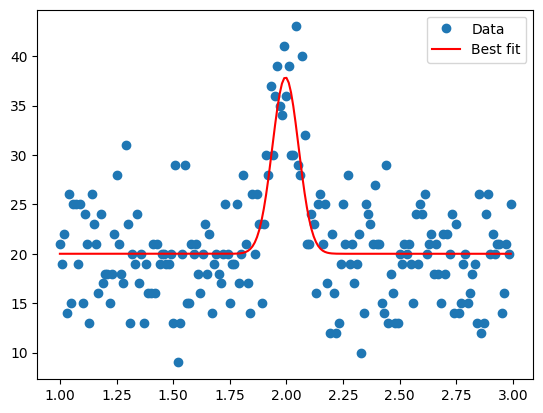

In [196]:
plt.plot(Ephotons, counts_data, 'o', label='Data')
plt.plot(Ephotons, calc_counts(Ephotons, best_A, best_E, best_width, cont_avg), label='Best fit', color='red')
plt.legend()